In [2]:
# This file we create dummy data for the three factor model and generate stocks data from it.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Generating the three factor data

# Number of observations
num_obs = 5000
num_factors = 3
num_trading_days = 365
start_date = pd.to_datetime('2000-01-01')

# Factor premiums (yearly decimal points)
rf = 0.01
mkt_rf = 0.05
smb = 0.01
hml = 0.02
random_shocks = 0

# GERENATE THE FACTOR RETURNS --------------------------------------------------------------------------------#
daily_factor_premiums = [mkt_rf / num_trading_days, smb / num_trading_days, hml / num_trading_days]
# Create some zero mean normal random shocks
shocks = np.random.normal(0, random_shocks / num_trading_days, (num_obs, num_factors + 1))

# Creating the factor returns
shocks[:, 0] = (shocks[:, 0] + daily_factor_premiums[0]) * 100
shocks[:, 1] = (shocks[:, 1] + daily_factor_premiums[1]) * 100
shocks[:, 2] = (shocks[:, 2] + daily_factor_premiums[2]) * 100
shocks[:, 3] = rf / num_trading_days * 100
# ------------------------------------------------------------------------------------------------------------#

# Make the returns a df
factor_returns = pd.DataFrame(shocks, columns=['Mkt-RF', 'SMB', 'HML', 'RF'])
# Create lagged returns
factor_returns['Mkt-RF_lag1'] = factor_returns['Mkt-RF'].shift(1)
factor_returns['SMB_lag1'] = factor_returns['SMB'].shift(1)
factor_returns['HML_lag1'] = factor_returns['HML'].shift(1)

# Drop the first row
factor_returns = factor_returns.dropna()

# Add a date column
factor_returns['date'] = pd.date_range(start_date, periods=num_obs - 1)

display(factor_returns.head())


,Mkt-RF,SMB,HML,RF,Mkt-RF_lag1,SMB_lag1,HML_lag1,date
1,0.013699,0.00274,0.005479,0.00274,0.013699,0.00274,0.005479,2000-01-01
2,0.013699,0.00274,0.005479,0.00274,0.013699,0.00274,0.005479,2000-01-02
3,0.013699,0.00274,0.005479,0.00274,0.013699,0.00274,0.005479,2000-01-03
4,0.013699,0.00274,0.005479,0.00274,0.013699,0.00274,0.005479,2000-01-04
5,0.013699,0.00274,0.005479,0.00274,0.013699,0.00274,0.005479,2000-01-05


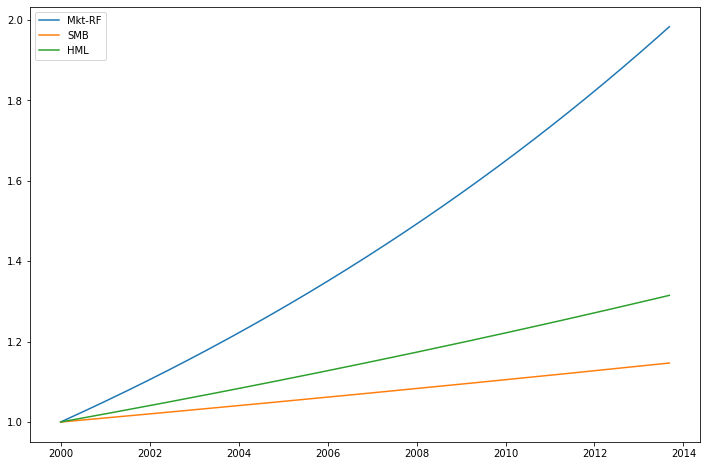

In [4]:
# Plot cumulative returns for Mkt-RF, SMB, HML
mkt_rf_cumulative_returns = (1 + factor_returns['Mkt-RF']/ 100).cumprod()
smb_cumulative_returns = (1 + factor_returns['SMB'] / 100).cumprod()
hml_cumulative_returns = (1 + factor_returns['HML'] / 100).cumprod()
dates = factor_returns['date']
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(dates, mkt_rf_cumulative_returns, label='Mkt-RF')
plt.plot(dates, smb_cumulative_returns, label='SMB')
plt.plot(dates, hml_cumulative_returns, label='HML')

plt.legend()
plt.show()


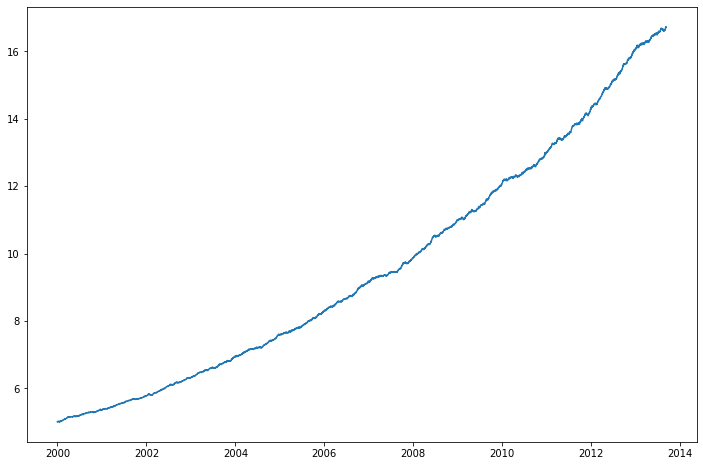

In [5]:


def generate_stock_prices_with_lag(alpha, mkt_factor_loading, smb_factor_loading, hml_factor_loading, mkt_factor_lagged_loading, smb_factor_lagged_loading, hml_factor_lagged_loading, noise_dev, factor_returns, num_trading_days = 252, starting_price = 5):
    """
    Generates stock prices from the three factor model.
    :param alpha: float, the alpha of the stock
    :param mkt_factor_loading: float, the market factor loading of the stock
    :param smb_factor_loading: float, the size factor loading of the stock
    :param hml_factor_loading: float, the value factor loading of the stock
    :param mkt_factor_lagged_loading: float, the lagged market factor loading of the stock
    :param smb_factor_lagged_loading: float, the lagged size factor loading of the stock
    :param hml_factor_lagged_loading: float, the lagged value factor loading of the stock
    :param noise_dev: float, the standard deviation of the noise
    :param factor_returns: pd.DataFrame, the factor returns
    :return: pd.DataFrame, the stock prices
    """
    alpha = (alpha / num_trading_days) * 100
    noise_dev = (noise_dev / num_trading_days) * 100

    # Generate the noise
    noise = np.random.normal(0, noise_dev, len(factor_returns))
    # Generate the stock returns
    stock_returns = alpha + mkt_factor_loading * factor_returns['Mkt-RF'] + smb_factor_loading * factor_returns['SMB'] + \
                    hml_factor_loading * factor_returns['HML'] + mkt_factor_lagged_loading * factor_returns['Mkt-RF_lag1'] + smb_factor_lagged_loading * factor_returns['SMB_lag1'] + \
                    hml_factor_lagged_loading * factor_returns['HML_lag1'] + factor_returns['RF'] + noise
    # Generate the stock prices
    stock_prices = (1 + stock_returns / 100).cumprod()
    stock_prices = stock_prices * starting_price
    # Make the stock prices a df
    stock_prices = pd.DataFrame(stock_prices, columns=['price'])
    # Add a date column
    stock_prices['date'] = factor_returns['date']
    return stock_prices


# Test the function
stock_prices = generate_stock_prices_with_lag(0.03, 0.5 , 0.5, 0.5, 0.1, 0.1, 0.1, 0.3 , factor_returns, num_trading_days=365)

# Plot the stock prices
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(stock_prices['date'], stock_prices['price'])
plt.show()

In [6]:
# Calculate the stock price returns
stock_returns = stock_prices['price'].pct_change().dropna()
# mean return
print('Mean return: ', (1 + stock_returns.mean()) ** 365)

Mean return:  1.0922348438086293


In [12]:
# Our final dataframe needs to have the following columns
# PERMNO, date, EXCHCD, SICCD, TICKER, TRDSTAT, CUSIP, DLSTCD, DLRET, PRC, RET, SHROUT, cusip, fdate, shares, institutional_ownership_perc

# Num stocks
num_stocks = 1
num_obs = 5000
start_date = pd.to_datetime('2000-01-01')

monthly_stock_data = pd.DataFrame()

for i in range(num_stocks):
    starting_price = 4.9
    alpha = 0
    institutional_ownership_perc = 0.3
    if(institutional_ownership_perc < 0.2):
        mkt_factor_loading = 1
        smb_factor_loading = 1
        hml_factor_loading = 1
        mkt_factor_loading_lagged = 1
        smb_factor_loading_lagged = 1
        hml_factor_loading_lagged = 1

    elif(institutional_ownership_perc < 0.4):
        mkt_factor_loading = 2
        smb_factor_loading = 2
        hml_factor_loading = 2
        mkt_factor_loading_lagged = 1.2
        smb_factor_loading_lagged = 1.2
        hml_factor_loading_lagged = 1.2

    elif(institutional_ownership_perc < 0.6):
        mkt_factor_loading = 1.5
        smb_factor_loading = 1.5
        hml_factor_loading = 1.5
        mkt_factor_loading_lagged = 1.5
        smb_factor_loading_lagged = 1.5
        hml_factor_loading_lagged = 1.5

    elif(institutional_ownership_perc < 0.8):
        mkt_factor_loading = 0.9
        smb_factor_loading = 0.9
        hml_factor_loading = 0.9
        mkt_factor_loading_lagged = 0.9
        smb_factor_loading_lagged = 0.9
        hml_factor_loading_lagged = 0.9

    else:
        mkt_factor_loading = 1
        smb_factor_loading = 1
        hml_factor_loading = 1
        mkt_factor_loading_lagged = 1
        smb_factor_loading_lagged = 1
        hml_factor_loading_lagged = 1

    
    noise_dev = np.random.uniform(0, 0.1)
    noise_dev = 0

    stock_prices = generate_stock_prices_with_lag(0.02, mkt_factor_loading, smb_factor_loading, hml_factor_loading, mkt_factor_loading_lagged, smb_factor_loading_lagged, hml_factor_loading_lagged, noise_dev, factor_returns, num_trading_days=365, starting_price=starting_price)
    # 9-digit CUSIP (random)
    cusip = ''.join([str(np.random.randint(0, 9)) for i in range(8)])
    # permno (random)
    permno = np.random.randint(0, 1000000)
    # Exchange code (random)
    exchcd = 1
    # SIC code (random)
    siccd = 2000
    # Ticker (random)
    ticker = ''.join([str(np.random.randint(0, 9)) for i in range(5)])
    # Trading status
    trdstat = 'A'
    # DLSTCD
    dlstcd =  np.NaN
    # DLRET
    dlret = np.NaN
    # RET; calc from stock prices['price']
    ret = stock_prices['price'].pct_change()
    # SHROUT
    shrout = 1000
    # date and fdate
    date = stock_prices['date']
    fdate = stock_prices['date']
    # shares
    shares = 10
    # institutional_ownership_perc
    institutional_ownership_perc = institutional_ownership_perc


    stock_df = pd.DataFrame({'PERMNO': permno, 'date': date, 'EXCHCD': exchcd, 'SICCD': siccd, 'TICKER': ticker, 'TRDSTAT': trdstat, 'CUSIP': cusip, 'DLSTCD': dlstcd, 'DLRET': dlret, 'PRC': stock_prices['price'], 'RET': ret, 'SHROUT': shrout, 'cusip': cusip, 'fdate': fdate, 'shares': shares, 'institutional_ownership_perc': institutional_ownership_perc}, index=range(num_obs - 1))

    # use pd.concat 
    monthly_stock_data = pd.concat([monthly_stock_data, stock_df], axis=0)

display(monthly_stock_data)


,PERMNO,date,EXCHCD,SICCD,TICKER,TRDSTAT,CUSIP,DLSTCD,DLRET,PRC,RET,SHROUT,cusip,fdate,shares,institutional_ownership_perc
0,709682,NaT,1,2000,60586,A,77538357,NaN,NaN,NaN,NaN,1000,77538357,NaT,10,0.3
1,709682,2000-01-01,1,2000,60586,A,77538357,NaN,NaN,4.903839,NaN,1000,77538357,2000-01-01,10,0.3
2,709682,2000-01-02,1,2000,60586,A,77538357,NaN,NaN,4.907682,0.000784,1000,77538357,2000-01-02,10,0.3
3,709682,2000-01-03,1,2000,60586,A,77538357,NaN,NaN,4.911527,0.000784,1000,77538357,2000-01-03,10,0.3
4,709682,2000-01-04,1,2000,60586,A,77538357,NaN,NaN,4.915376,0.000784,1000,77538357,2000-01-04,10,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,709682,2013-09-02,1,2000,60586,A,77538357,NaN,NaN,244.890158,0.000784,1000,77538357,2013-09-02,10,0.3
4995,709682,2013-09-03,1,2000,60586,A,77538357,NaN,NaN,245.082044,0.000784,1000,77538357,2013-09-03,10,0.3
4996,709682,2013-09-04,1,2000,60586,A,77538357,NaN,NaN,245.274081,0.000784,1000,77538357,2013-09-04,10,0.3
4997,709682,2013-09-05,1,2000,60586,A,77538357,NaN,NaN,245.466269,0.000784,1000,77538357,2013-09-05,10,0.3


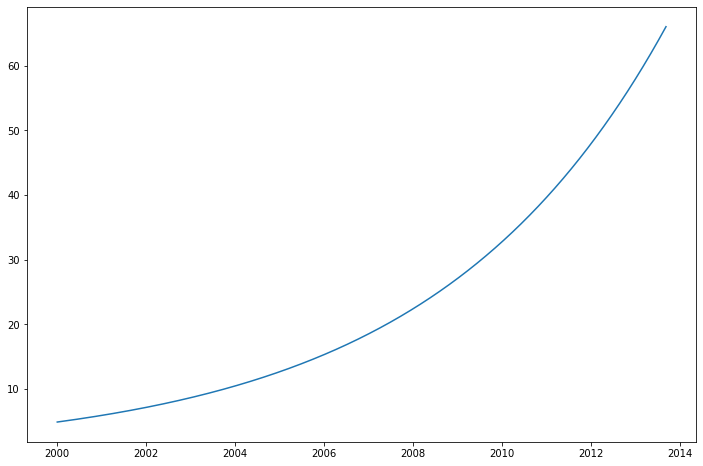

In [8]:

stock_data = monthly_stock_data

# Plot the stock prices
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(stock_data['date'], stock_data['PRC'])
plt.show()


In [9]:
# Calculate expected 30-day 90-day and 180-day returns for institutional ownership < 0.2
def e_return(alpha, mkt_factor_loading, smb_factor_loading, hml_factor_loading):
    ret = alpha + mkt_factor_loading * mkt_rf + smb_factor_loading * smb + hml_factor_loading * hml + rf

    print('Expected 30-day return: ', (1 + ret / 365) ** 30 - 1)
    print('Expected 90-day return: ', (1 + ret / 365) ** 90 - 1)
    print('Expected 180-day return: ', (1 + ret / 365) ** 180 - 1)

    print('\n\n')

alpha = 0

# 1
e_return(alpha, 1, 1, 1)
# 1.2
e_return(alpha, 1.2, 1.2, 1.2)
# 1.5
e_return(alpha, 1.5, 1.5, 1.5)
# 0.9
e_return(alpha, 0.9, 0.9, 0.9)
# 1
e_return(alpha, 1, 1, 1)


                

Expected 30-day return:  0.007423768980227008
Expected 90-day return:  0.022437053119620076
Expected 180-day return:  0.04537752759193281



Expected 30-day return:  0.00874911566164549
Expected 90-day return:  0.02647765777829303
Expected 180-day return:  0.053656381918010476



Expected 30-day return:  0.010740296466304367
Expected 90-day return:  0.03256819023928248
Expected 180-day return:  0.06619706749402732



Expected 30-day return:  0.006761727020726083
Expected 90-day return:  0.020422653071685337
Expected 180-day return:  0.04126239090185724



Expected 30-day return:  0.007423768980227008
Expected 90-day return:  0.022437053119620076
Expected 180-day return:  0.04537752759193281





In [13]:
# export as pickle file
monthly_stock_data.to_pickle('./../data/merged_price_instit_data_simulated.pkl')
factor_returns.to_pickle('./../data/factor_returns_simulated_1.pkl')

